# Check emission pairs to see which are missing in construction

In [27]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
sys.path.append("..")

from src.examples.example_setups import setup_stat_scm, setup_ind_scm
from src.utils.sequential_causal_functions import sequentially_sample_model
from numpy.random import seed
import numpy as np
from src.utils.plotting import plot_outcome

from src.utils.sem_utils.toy_sems import StationaryDependentSEM as StatSEM
from src.utils.sem_utils.toy_sems import StationaryIndependentSEM as StatIndSEM
from src.methods.bo import BO
from src.methods.cbo import CBO
from src.methods.abo import ABO
from src.methods.dcbo import DCBO
seed(seed=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


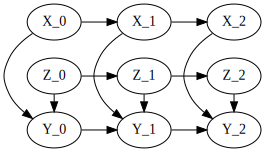

In [34]:

T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, G_view, G, exploration_sets, intervention_domain, true_objective_values  = setup_ind_scm(T)
# This is just a snapshot of the DAG at hand
G_view

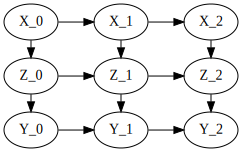

In [42]:
T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, G_view, G, exploration_sets, intervention_domain, true_objective_values  = setup_stat_scm(T)
# This is just a snapshot of the DAG at hand
G_view

In [36]:
# Multiple children per node
G.add_edge("Z_0","X_0")
G.add_edge("Z_1","X_1")
G.add_edge("Z_2","X_2")

G.remove_edge("X_0","Z_0")
G.remove_edge("X_1","Z_1")
G.remove_edge("X_2","Z_2")

In [43]:
# Multiple incoming edges
G.add_edge("X_0","Y_0")
G.add_edge("X_1","Y_1")
G.add_edge("X_2","Y_2")

0

In [8]:

# Number of independent samples (samples here are the time-series on the horizontal) per time-index
D_Obs = sequentially_sample_model(init_sem,
                                sem,
                                total_timesteps=T,
                                sample_count=5, # How many samples we take per node in each time-slice
                                epsilon=None) # If we employ a noise model or not

D_Obs

{'X': array([[ 1.76405235,  2.16420955,  3.14294754],
        [ 0.4105985 ,  0.55464207,  2.00891558],
        [ 0.3130677 , -0.54102804, -3.09401785],
        [-0.18718385,  1.34559536,  2.81495413],
        [ 1.23029068,  2.43267053,  2.04534371]]),
 'Z': array([[ 2.41224229e+00,  4.39464095e+00,  3.46051848e+00],
        [ 1.42429090e+00,  2.12024369e+00,  2.69824097e+00],
        [ 1.38481900e+00,  3.96702709e+00,  2.52904184e+01],
        [ 1.36079639e+00,  1.99934354e+00,  1.17146526e+00],
        [-1.00951244e-02, -9.70846048e-01, -2.26152826e+00]]),
 'Y': array([[-0.68189676, -1.94841594, -3.84232337],
        [-0.45160585, -0.37915648, -2.36142647],
        [ 1.52155989, -1.43112523, -0.68014656],
        [-2.7065599 , -4.374889  , -4.77284705],
        [-1.70682603, -0.24118898, -2.50766016]])}

In [28]:
# Setup the input parameters to be used with the Bayesian optimization
BO_input_params = {
    "G": G,
    "sem": StatSEM,
    "base_target_variable": "Y",
    "observation_samples": D_Obs,
    "intervention_domain": intervention_domain,
    "intervention_samples":None,   
    "number_of_trials": 10,
    "optimal_assigned_blankets": None,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "change_points": None
}
# Run Bayesian optimization
bo = BO(**BO_input_params)
bo.run()

Time index:  33%|███▎      | 1/3 [00:00<00:00,  4.62it/s]reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.143006475028315
Optimization restart 1/1, f = 4.434249159697096
Optimization restart 1/1, f = 5.577456306806231
Optimization restart 1/1, f = 6.311967728739278
Optimization restart 1/1, f = 8.46191778185456
Optimization restart 1/1, f = 8.226112269470772
Optimization restart 1/1, f = 8.335995430339224
Optimization restart 1/1, f = 7.850581043249649
Optimization restart 1/1, f = 6.181457170192694
Optimization restart 1/1, f = 2.9946539384950763
Optimization restart 1/1, f = 6.134175859377086

Time index:  67%|██████▋   | 2/3 [00:00<00:00,  4.42it/s]reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 10.567441329581792
Optimization restart 1/1, f = 11.88775947029168
Optimization restart 1/1, f = 13.226613664939904
Optimization restart 1/1, f = 16.210552115805246
Optimization restart 1/1, f = 15.911447362525013
Optimization restart 1/1, f = 15.92806164841201
Optimization restart 1/1, f = 15.14834856574356
Optimization restart 1/1, f = 7.649377033978306
Optimization restart 1/1, f = 8.70684551258357
Optimization restart 1/1, f = 7.5592662526228835
Optimization restart 1/1, f = 6.1093056130409495
Optimization restart 1/1, f = 13.419054002033736
Optimization restart 1/1, f = 14.046107758809118

Time index: 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


Optimization restart 1/1, f = 12.919428835380973
Optimization restart 1/1, f = 16.348118906500428
Optimization restart 1/1, f = 17.11180857679513


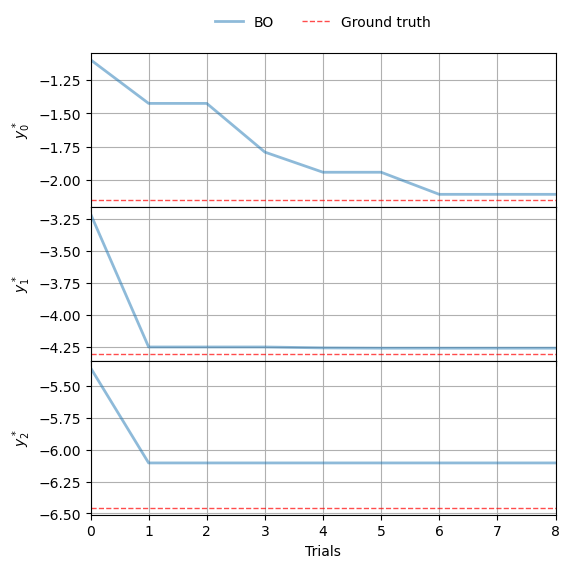

In [29]:
plot_outcome(3,10,outcomes=[bo.optimal_outcome_values_during_trials],labels=['BO'],true_objective_values=true_objective_values)

In [30]:
abo = ABO(**BO_input_params)
abo.run()

Time index:  33%|███▎      | 1/3 [00:00<00:00,  4.71it/s]reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.143006475028315
Optimization restart 1/1, f = 4.434249159697096
Optimization restart 1/1, f = 5.577456306806231
Optimization restart 1/1, f = 6.311967728739278
Optimization restart 1/1, f = 8.46191778185456
Optimization restart 1/1, f = 8.226112269470772
Optimization restart 1/1, f = 8.335995430339224
Optimization restart 1/1, f = 7.850581043249649
Optimization restart 1/1, f = 6.181457170192694
Optimization restart 1/1, f = 12.865012668719162


Time index:  67%|██████▋   | 2/3 [00:00<00:00,  4.31it/s]reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 11.819638265536728
Optimization restart 1/1, f = 9.801206720930248
Optimization restart 1/1, f = 7.556557869179121
Optimization restart 1/1, f = 12.949807878821627
Optimization restart 1/1, f = 13.620928998422164
Optimization restart 1/1, f = 15.63052374392776
Optimization restart 1/1, f = 14.225398702578584
Optimization restart 1/1, f = 16.811054246800353
Optimization restart 1/1, f = 18.26688443632344
Optimization restart 1/1, f = 17.916404093274693
Optimization restart 1/1, f = 17.73580226365098
Optimization restart 1/1, f = 16.178511288518038
Optimization restart 1/1, f = 13.80439173868917
Optimization restart 1/1, f = 12.69880999555464
Optimization restart 1/1, f = 10.65740656340628
Optimization restart 1/1, f = 11.404585357615092
Optimization restart 1/1, f = 11.312718293992738


Time index: 100%|██████████| 3/3 [00:00<00:00,  4.18it/s]


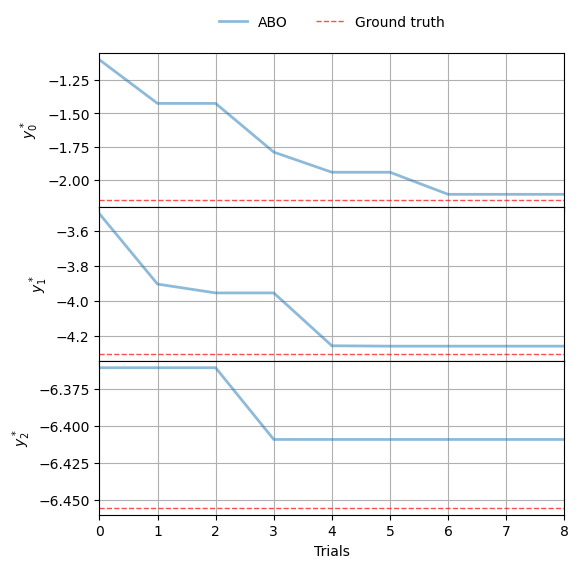

In [26]:
plot_outcome(3,10,outcomes=[abo.optimal_outcome_values_during_trials],labels=['ABO'],true_objective_values=true_objective_values)

In [46]:
from src.utils.sem_utils.emissions import fit_sem_emit_fncs
from src.utils.dag_utils.adjacency_matrix_utils import get_emit_and_trans_adjacency_mats

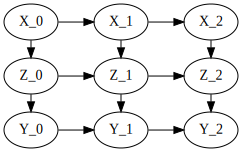

In [45]:
G_view

In [99]:
emit_adj_mat, _ = get_emit_and_trans_adjacency_mats(G)

In [126]:
emit_adj_mat.sum()

9

In [103]:
coords =  np.where(emit_adj_mat[0,:] == 1)
nodes[coords]

array(['Z_0', 'Y_0'], dtype='<U3')

In [125]:
nodes[3]

'X_1'

In [128]:
G.T = 3
fit_sem_emit_fncs(G, D_Obs)

{0: {('X', 0, 'Z'): <GPy.models.gp_regression.GPRegression at 0x7ff1d155f710>,
  ('X', 1, 'Y'): <GPy.models.gp_regression.GPRegression at 0x7ff208efe050>,
  (None, 'X'): KernelDensity(),
  ('Z',): <GPy.models.gp_regression.GPRegression at 0x7ff268b0b250>},
 1: {('X', 0, 'Z'): <GPy.models.gp_regression.GPRegression at 0x7ff1e8c0cd10>,
  ('X', 1, 'Y'): <GPy.models.gp_regression.GPRegression at 0x7ff208f22f50>,
  ('Z',): <GPy.models.gp_regression.GPRegression at 0x7ff268b08190>},
 2: {('X', 0, 'Z'): <GPy.models.gp_regression.GPRegression at 0x7ff208f161d0>,
  ('X', 1, 'Y'): <GPy.models.gp_regression.GPRegression at 0x7ff208f2d850>,
  ('Z',): <GPy.models.gp_regression.GPRegression at 0x7ff268b15450>}}